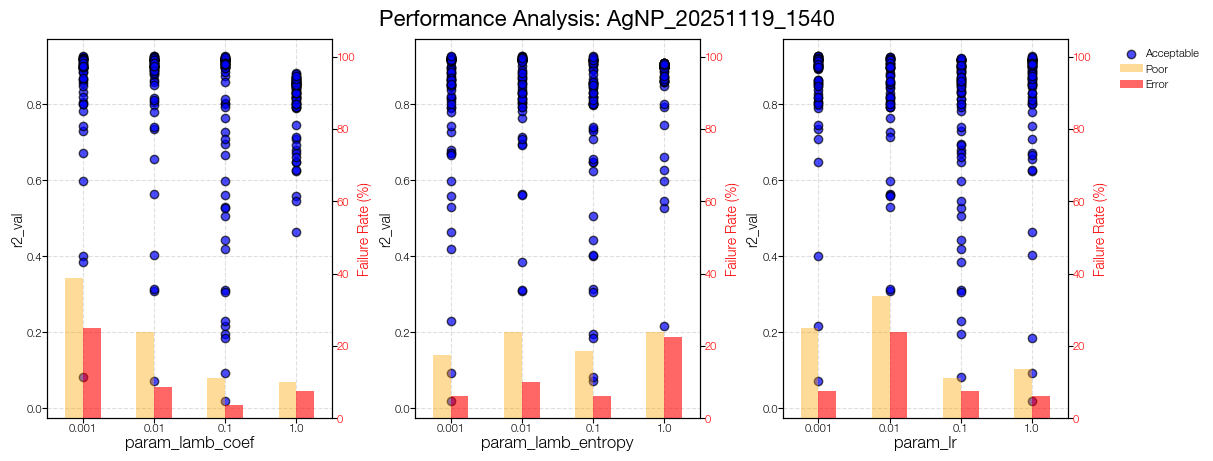

In [1]:
import pandas as pd
import os
from kan.experiments.multkan_hparam_sweep import plot_parameter_performance

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures", "material_02")
os.makedirs(save_dir, exist_ok=True)

f_param = "AgNP_20251119_1540"
plot_parameter_performance(f_param, root_dir)

In [2]:
save_heading = os.path.join(save_dir, f_param + "_analysis")
d_opt = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', f_param + ".xlsx"), sheet_name='best_avg_by_params')
d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr
import torch

filepath = os.path.join(root_dir, "data", "AgNP.csv")
filedata = pd.read_csv(filepath)
name_X = filedata.columns[:-1].tolist()
name_y = filedata.columns[-1]
df_in = filedata[name_X]
df_out = filedata[[name_y]]
print(f"TARGET: {name_y}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)

removed_count = len(df_in) - len(df_in_final)
print(f"# of data after removing outliers: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")

X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)
print(f"Train set: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validation set: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

y = df_out_final[name_y].values.reshape(-1, 1)

TARGET: loss
# of data after removing outliers: 3295 개 (0 개 제거됨)
Train set: 2108 (64.0%)
Validation set: 528 (16.0%)
Test set: 659 (20.0%)


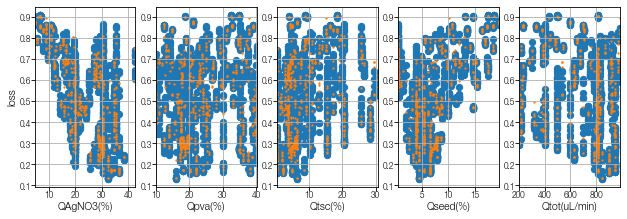

In [4]:
import matplotlib.pyplot as plt

num_input = X.shape[1]
fig, axs = plt.subplots(1, num_input, figsize=(10, 3))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X_train[:, i], y_train)
    ax.scatter(X_test[:, i], y_test, s=1.5)
    ax.set_xlabel(name_X[i])
    ax.grid()
axs[0].set_ylabel(name_y)
plt.show()


| train_loss: 8.80e-02 | test_loss: 8.37e-02 | reg: 2.18e+00 | : 100%|█| 50/50 [00:32<00:00,  1.54it


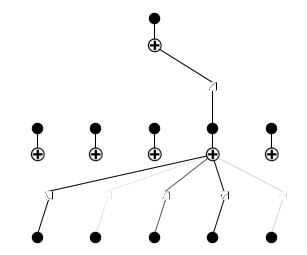

| train_loss: 8.66e-02 | test_loss: 8.22e-02 | reg: 2.09e+00 | : 100%|█| 50/50 [00:30<00:00,  1.66it


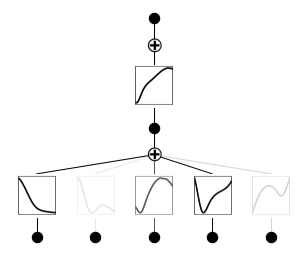

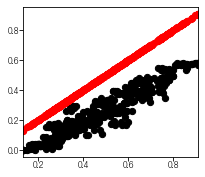

TrialResult(params={'grid': 30, 'k': 3, 'lamb': 0.01, 'lamb_coef': 0.1, 'lamb_entropy': 0.01, 'lr': 0.001, 'mult_arity': 0, 'opt': 'LBFGS', 'prune': True, 'pruning_edge_th': 0.03, 'pruning_node_th': 0.01, 'steps': 50, 'update_grid': True, 'width': [[5, 0], [5, 0], [1, 0]], 'max_grid': 3}, val_loss=0.2292514592409134, train_loss=0.22943025827407837, test_loss=0.23132328689098358, r2_train=-0.4801486954292866, r2_val=-0.44736885222380374, r2_test=-0.3777040233051532, seed=0, device='cpu', spline_train_loss=0.08786375820636749, spline_test_loss=0.08361514657735825)


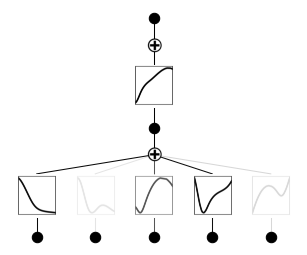

In [5]:
from kan.experiments.multkan_hparam_sweep import evaluate_params
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}
params['max_grid'] = 3

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm, 0, scaler_y, device.type,
    save_heading=save_heading
)
print(res)
model.plot()
plt.show()

r2 is 0.9999406933784485
fixing (0,0,0) with tanh, r2=1.0, c=3
Best value at boundary.
r2 is 0.9446563720703125
fixing (0,1,0) with tanh, r2=0.95, c=3
r2 is 0.9938656687736511
fixing (0,2,0) with gaussian, r2=0.98, c=3
r2 is 0.8470167517662048
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,3,0) with gaussian, r2=0.85, c=3
r2 is 0.6399229168891907
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,4,0) with cos, r2=0.64, c=2
Best value at boundary.
r2 is 0.9961779117584229
fixing (1,0,0) with arctan, r2=1.0, c=4


| train_loss: 9.96e-02 | test_loss: 9.15e-02 | reg: 1.86e-01 | : 100%|█| 50/50 [00:17<00:00,  2.87it


-1.4812*atan(0.0246*cos(9.6694*x_5 - 0.6143) + 1.2215*tanh(4.1462*x_1 - 0.5992) + 0.0343*tanh(9.988*x_2 - 1.6337) - 3.4061 + 0.9725*exp(-31.5386*(0.2709 - x_4)**2) + 0.4555*exp(-15.6756*(0.1445 - x_3)**2)) - 0.9663

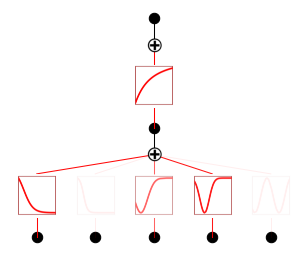

In [6]:
from kan.utils import ex_round
model.auto_symbolic(weight_simple=0, a_range=(-50, 50), b_range=(-50, 50))
model.fit(dataset, **fit_kwargs)
model.plot()
ex_round(model.symbolic_formula()[0][0], 4)

{'train': 0.8442324673171161, 'test': 0.8787156249697512}


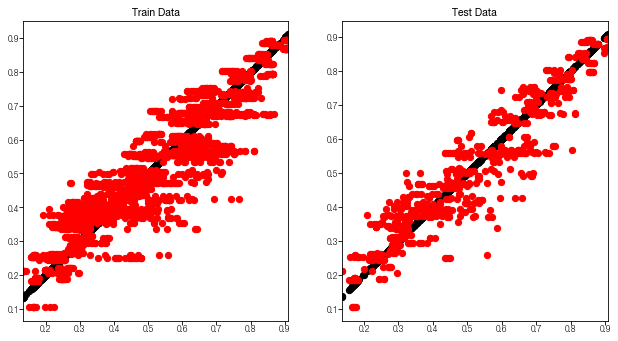

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='k')
ax_train.scatter(y_train, y_pred_train, color='r')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='k')
ax_test.scatter(y_test, y_pred_test, color='r')
ax_test.set_title("Test Data")

plt.show()
plt.show()

Text(0, 0.5, 'Attribution score')

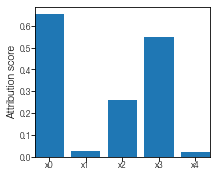

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

Layer 0 : in 0 -- out 0
Slope: [0.002393303264398128, -0.0031395722767229017, -5.182471750231343e-05, 1.4138215192360803e-05, -0.0001000786323857028]
[1.0, 1.0, 1.0, 1.0, 1.0]
Inflection point: None
Layer 0 : in 1 -- out 0
Slope: [-0.00019526761752786115, -0.0001629858888918534, -0.000804217743279878, 0.0016637613880448043, -0.00040469676605425775]
[-1.0, -1.0, -1.0, -1.0, -1.0]
Inflection point: None
Layer 0 : in 2 -- out 0
Slope: [-0.007386948796920478, 0.011613859562203288, -0.0015798010863363743, -0.0023318708408623934, 0.0017433674656786025]
[-1.0, 1.0, 1.0, 1.0, 1.0]
Inflection point: 0.0
Layer 0 : in 3 -- out 0
Slope: [-0.00032375799492001534, 0.00042227908852510154, 0.0007997130742296576, 0.0004087903944309801, -0.0007145802446757443]
[-1.0, -1.0, -1.0, -1.0, -1.0]
Inflection point: None
Layer 0 : in 4 -- out 0
Slope: [-0.0012794099748134613, 0.000251564767495438, -0.0010521685353523935, 0.0016211557667702436, 0.00031423737527802587]
[-1.0, -1.0, -1.0, -1.0, -1.0]
Inflection po

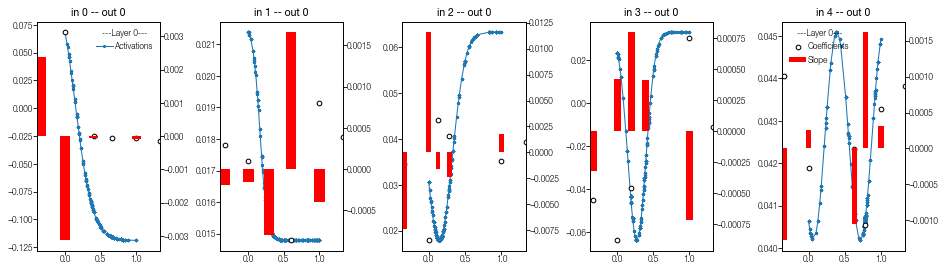

In [17]:
import numpy as np

def find_index_sign_revert(data_list, epsilon=5e-3):
    """
    Finds the first index where the sign changes and persists for
    more than one element.

    Values with absolute magnitude smaller than epsilon are treated as having the same sign as the previous element, effectively ignoring small fluctuations around zero.

    Args:
        data_list (list): A list of numbers.
        epsilon (float): The threshold below which a value is considered to have "no sign change" relative to the previous value.

    Returns:
        int or None: The first index of a persistent sign change,
                     or None if no such change is found.
    """
    # if len(data_list) < 3:
    #     return None

    effective_signs = [np.sign(data_list[0])]

    for i in range(1, len(data_list)):
        val = data_list[i]
        prev_sign = effective_signs[-1]

        if abs(val) < epsilon:
            effective_signs.append(prev_sign)
        else:
            effective_signs.append(np.sign(val))
    print(effective_signs)

    # Now search for the persistent sign change using these cleaned signs
    for i in range(1, len(effective_signs) - 1):
        if effective_signs[i] != effective_signs[i-1]:
            if effective_signs[i+1] == effective_signs[i]:
                return i

    return None

depth = len(model.act_fun)
layers_to_plot = [0]
inflection_points = []

for l in layers_to_plot:
    act = model.act_fun[l]
    ni, no = act.coef.shape[:2]
    coef = act.coef.tolist()
    inflection_points_per_layer = []

    fig, axs = plt.subplots(nrows=no, ncols=ni, squeeze=False,
                            figsize=(max(2.5*ni, 6), max(2.5*no, 3.5)),
                            constrained_layout=True)
    second_axs = np.zeros_like(axs)
    for i in range(ni):
        for j in range(no):
            ax = axs[j, i]
            # Gather pre- and post-activations and sort by input
            inputs = model.spline_preacts[l][:, j, i].cpu().detach().numpy()
            outputs = model.spline_postacts[l][:, j, i].cpu().detach().numpy()
            output_spline = model.spline_postsplines[l][:, j, i].cpu().detach().numpy() # without base function values
            coef_node = coef[i][j]
            num_knot = act.grid.shape[1]
            spline_radius = int((num_knot - len(coef_node)) / 2)
            bar_width = min(act.grid[i, 1:] - act.grid[i, :-1]) / 2

            rank = np.argsort(inputs)
            ax.plot(inputs[rank], outputs[rank], marker='o', ms=2, lw=1, label='Activations')
            # ax.plot(inputs[rank], output_spline[rank], marker='^', ms=1, lw=1, label='Splines Only')

            ax2 = ax.twinx()
            second_axs[j, i] = ax2
            ax2.scatter(act.grid[i, spline_radius:-spline_radius], coef_node,
                       s=20, color='white', edgecolor='k', label='Coefficients')
            slope = [x - y for x, y in zip(coef_node[1:], coef_node[:-1])]
            slope_2nd = [(x - y)*10 for x, y in zip(slope[1:], slope[:-1])]
            bars = ax2.bar(act.grid[i, spline_radius:-(spline_radius + 1)], slope,
                    width=bar_width, align='center', color='r', label='Slope')
            ax.set_title(f'in {i} -- out {j}', fontsize=10)

            print(f'Layer {l} : in {i} -- out {j}')
            print(f'Slope: {slope}')

            idx_revert = find_index_sign_revert(slope)
            if idx_revert is None:
                inflection_val = None
            else:
                inflection_val = act.grid[i, spline_radius + idx_revert]
            inflection_points_per_layer.append(inflection_val)

            print(f'Inflection point: {inflection_val}')
    axs[0, 0].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    second_axs[-1, -1].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    inflection_points.append(inflection_points_per_layer)

    plt.show()

[tensor(34), tensor(2074)]


C:\Users\user\AppData\Local\Temp\ipykernel_32272\63661861.py:20: RuntimeWarning: invalid value encountered in divide
  score_norm = score_masked / x_std


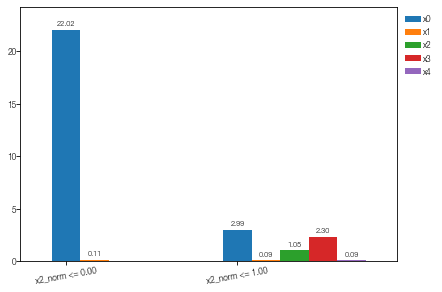

In [16]:
mask_idx = 2
mask_interval = [-1, inflection_points[0][mask_idx], 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'x{mask_idx}_norm <= {ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_norm = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        x_std = torch.std(x_tensor_masked, dim=0).detach().cpu().numpy()
        model.forward(x_tensor_masked)

        score_masked = model.feature_score.detach().cpu().numpy()
        score_norm = score_masked / x_std
        scores_interval.append(score_masked)
        scores_interval_norm.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_norm.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval_norm])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval_norm], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

In [15]:
inflection_points

[[None, None, tensor(0.), None, None]]